In [2]:
import os
import requests
import pandas as pd
from io import BytesIO
from zipfile import ZipFile
from plotnine import ggplot, aes, geom_histogram, theme_minimal, scale_fill_manual
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

In [18]:
class Airplane():
    """
    A class to download airplane data and perform analysis on it.
    """

    def __init__(self):
        self.airlines_df = pd.DataFrame()
        self.airplanes_df = pd.DataFrame()
        self.airports_df = pd.DataFrame()
        self.routes_df = pd.DataFrame()
        self.merge_df = pd.DataFrame()

    def download_data(self):
        """
        Checks for a 'downloads' folder and creates it if it doesn't exist.
        Downloads flight data from a GitHub repository as a zip file, saves it,
        extracts the contents, and creates Pandas DataFrames from the CSV files:
        - airlines.csv
        - airplanes.csv
        - airports.csv
        - routes.csv
        """

        downloads_dir = "downloads"
        if not os.path.exists(downloads_dir):
            os.makedirs(downloads_dir)

        zip_file_path = os.path.join(downloads_dir, "flight_data.zip")

        """
        Check if the zip file was already downloaded
        """
        if not os.path.exists(zip_file_path):
            response = requests.get(
                "https://gitlab.com/adpro1/adpro2024/-/"
                "raw/main/Files/flight_data.zip?inline=false",
                stream=True,
            )
            """
            Ensure the request is successful
            """
            if response.status_code == 200:
                with open(zip_file_path, "wb") as f:
                    f.write(response.content)

        """
        Extract files if the zip file is downloaded
        """
        if os.path.exists(zip_file_path):
            with ZipFile(zip_file_path, "r") as zip_ref:
                zip_ref.extractall(downloads_dir)

                """
                Loading data into DataFrames
                """
                self.airlines_df = pd.read_csv(
                    os.path.join(downloads_dir, "airlines.csv")
                )
                self.airplanes_df = pd.read_csv(
                    os.path.join(downloads_dir, "airplanes.csv")
                )
                self.airports_df = pd.read_csv(
                    os.path.join(downloads_dir, "airports.csv")
                )
                self.routes_df = pd.read_csv(os.path.join(downloads_dir, "routes.csv"))

        """
        Print the first 5 lines of each dataset
        """
        #print("Airlines DataFrame:\n", self.airlines_df.head())
        #print("\nAirplanes DataFrame:\n", self.airplanes_df.head())
        #print("\nAirports DataFrame:\n", self.airports_df.head())
        #print("\nRoutes DataFrame:\n", self.routes_df.head())

        #print("\nDownloaded data executed!")
        
    def merge_datasets(self) -> pd.DataFrame:
    
        self.airlines_df = self.airlines_df.drop(self.airlines_df.columns[0], axis=1).reset_index(drop=True)
        self.airports_df= self.airports_df.drop(self.airports_df.columns[0], axis=1).reset_index(drop=True)
        self.airports_df = self.airports_df.drop(['Type', 'Source'], axis=1)
        self.routes_df= self.routes_df.drop(self.routes_df.columns[0], axis=1).reset_index(drop=True)
        self.airplanes_df= self.airplanes_df.drop(self.airplanes_df.columns[0], axis=1).reset_index(drop=True)

        merge_df_1 = pd.merge(self.airports_df,self.routes_df, left_on="IATA", right_on="Source airport", how="left")
        merge_df_1 = merge_df_1.rename(columns={"Country": "Source country","Latitude": "latitude_source","Longitude": "longitude_source"})
        
        merge_df = pd.merge(merge_df_1,self.airports_df[["IATA", "Country", "Latitude", "Longitude"]],left_on="Destination airport",right_on="IATA", how='left')
        merge_df = merge_df.rename(columns={'IATA_x':"IATA", "Country": "Destination country","Latitude": "latitude_destination","Longitude": "longitude_destination"})
        merge_df = merge_df.dropna(subset=["Source country", "Destination country"])
        #Drop the columns that I dont need
        merge_df.drop(columns=['IATA_y'], inplace=True)

        # Assign the resulting merge_df to the instance variable
        self.merge_df = merge_df
        
        #print("Merge DataFrame:\n", self.merge_df.head())

        return self.merge_df
    
    def plot_airports_in_country(self, country):
        """
        Plot airports within the chosen country and use the ICAOs as legends.

        Parameters:
        - country (str): The name of the country where airports are to be plotted.
        """
        # Filter airports by the specified country
        country_airports = self.airports_df[self.airports_df["Country"] == country]

        # Exit if no airports are found in the country
        if country_airports.empty:
            print(f"No airports found in {country}.")
            return

        # Load a map of the world
        world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

        # Filter the map to only include the specified country
        country_map = world[world["name"] == country]

        # Exit if the country is not found in the map dataset
        if country_map.empty:
            print(f"Country '{country}' not found.")
            return

        # Convert the filtered airports data into a GeoDataFrame
        gdf_airports = gpd.GeoDataFrame(
            country_airports,
            geometry=gpd.points_from_xy(
                country_airports.Longitude, country_airports.Latitude
            ),
        )

        # Plotting
        _, axis = plt.subplots(figsize=(10, 10))
        country_map.plot(ax=axis, color="lightgrey")
        gdf_airports.plot(ax=axis, marker="o", color="red", markersize=5)

        # Annotate each airport with its ICAO code
        for _, row in gdf_airports.iterrows():
            axis.text(row.geometry.x, row.geometry.y, row["ICAO"], fontsize=8)

        plt.title(f"Airports in {country}")
        plt.show()

    def distance_analysis(self):
        self.merge_df["distance"] = self.merge_df.apply(
            lambda row: distance_geo(
                row["latitude_source"],
                row["longitude_source"],
                row["latitude_destination"],
                row["longitude_destination"],
            ),
            axis=1,
        )

        self.merge_df["distance"].head()

        distance_plot = (
            ggplot(self.merge_df, aes(x="distance"))
            + geom_histogram(bins=30, fill="#5496BF", color="black")
            + theme_minimal()
            + scale_fill_manual(
                values=["#011526", "#C9DFF2", "#5496BF", "#75B2BF", "#025159"]
            )
        )
        return distance_plot

    def plot_flights_by_code_airports(self, code_airport, n=5, internal=False):

        country_of_source = self.merge_df.loc[
            self.merge_df["Source airport"] == code_airport, "Source country"
        ].iloc[0]

        if internal:
            # Plot only internal flights
            internal_routes = self.merge_df[
                (self.merge_df["Source airport"] == code_airport)
                & (self.merge_df["Destination airport"] == code_airport)
            ]
            # Limit to top n destination airports
            internal_routes["Destination airport"].value_counts().head(n).plot(
                kind="bar", title=f"Top {n} Internal Flights from {code_airport}"
            )
        else:
            # Plot all flights
            all_routes = self.merge_df[self.merge_df["Source airport"] == code_airport]
            # Limit to top n destination airports
            all_routes["Destination airport"].value_counts().head(n).plot(
                kind="bar", title=f"Top {n} Flights from {code_airport}"
            )
        plt.xlabel("Destination Airport")
        plt.ylabel("Number of Flights")
        plt.show()

    def plot_most_used_airplane_models(self, n: int = 5, countries=None):
        """
        Plot the most used airplane models based on the number of routes.

        Parameters:
            n (int): Number of airplane models to plot, that by default is 5.
            countries: Specific country or list of countries to consider, by default is None.
        """
        if countries is None:
            # Plot most used planes by route using the entire dataset
            top_airplanes = self.merge_df["Equipment"].value_counts().nlargest(n)
        else:
            # Plot most used planes by route for a specific country or list of countries
            if isinstance(countries, str):
                countries = [countries]

            filtered_routes = self.merge_df[
                self.merge_df["Source country"].isin(countries)
            ]
            top_airplanes = filtered_routes["Equipment"].value_counts().nlargest(n)

        top_airplanes.plot(
            kind="bar", title=f"Top {n} Airplane Models by Number of Routes"
        )
        plt.xlabel("Airplane Model")
        plt.ylabel("Number of Routes")
        plt.show()

    def plot_flights_by_country(self, country, internal=False):
        """
        Plot flights based on the country, with an option to include only internal flights.

        Parameters:
        - country (str): The name of the country for which flights are to be plotted.
        - internal (bool): If True, plot only internal flights. If False, plot all flights. Default is False.
        """
        # Filter routes by the specified country

        if internal is True:
            # Plot only internal flights
            internal_routes = self.merge_df[
                (self.merge_df["Source country"] == country)
                & (self.merge_df["Destination country"] == country)
            ]
            
            # Exit if no routes are found in the country
            if internal_routes.empty:
                print(f"No routes found for {country}.")
                return

            # Load a map of the world
            world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

            # Filter the map to only include the specified country
            country_map = world[world["name"] == country]

            # Exit if the country is not found in the map dataset
            if internal_routes.empty:
                print(f"Country '{country}' not found.")
                return

            # Convert the filtered routes data into a GeoDataFrame
            gdf_routes = gpd.GeoDataFrame(
                internal_routes,
                geometry=gpd.points_from_xy(
                    internal_routes.longitude_source, internal_routes.latitude_source
                ),
            )

            # Plotting
            _, axis = plt.subplots(figsize=(10, 10))
            country_map.plot(ax=axis, color="lightgrey")

            # Plot airports
            gdf_routes.plot(ax=axis, marker="o", color="blue", markersize=5, label='Airports')
        
            # Plot routes
            for _, row in gdf_routes.iterrows():
                dest_coords = (
                    row["longitude_destination"],
                    row["latitude_destination"]
                )
                route = LineString([Point(row.geometry.x, row.geometry.y), Point(dest_coords)])
                gpd.GeoDataFrame(geometry=[route]).plot(ax=axis, color='red', label='Routes')

            plt.title(f"Internal flights from {country}")
            plt.legend()
            plt.show()

            
        else:
            all_routes = self.merge_df[
                (self.merge_df["Source country"] == country)
            ]
             # Exit if no routes are found in the country
            if all_routes.empty:
                print(f"No routes found for {country}.")
                return

            # Load a map of the world
            world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

            # Exit if the country is not found in the map dataset
            if all_routes.empty:
                print(f"Country '{country}' not found.")
                return

            # Convert the filtered routes data into a GeoDataFrame
            gdf_routes = gpd.GeoDataFrame(
                all_routes,
                geometry=gpd.points_from_xy(
                    all_routes.longitude_source, all_routes.latitude_source
                ),
            )

            # Plotting
            _, axis = plt.subplots(figsize=(10, 10))
            world.plot(ax=axis, color="lightgrey")

            # Plot airports
            gdf_routes.plot(ax=axis, marker="o", color="blue", markersize=5, label='Airports')
        
            # Plot routes
            for _, row in gdf_routes.iterrows():
                dest_coords = (
                    row["longitude_destination"],
                    row["latitude_destination"]
                )
                route = LineString([Point(row.geometry.x, row.geometry.y), Point(dest_coords)])
                gpd.GeoDataFrame(geometry=[route]).plot(ax=axis, color='red', label='Routes')

            plt.title(f"Internal flights from {country}")
            plt.legend()
            plt.show()



In [19]:
# Create an instance of the Airplane class
airplane_instance = Airplane()

# Download data and merge datasets
airplane_instance.download_data()
airplane_instance.merge_datasets()

,Airport ID,Name,City,Source country,IATA,ICAO,latitude_source,longitude_source,Altitude,Timezone,...,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment,Destination country,latitude_destination,longitude_destination
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,...,GKA,1,HGU,3,NaN,0.0,DH8 DHT,Papua New Guinea,-5.826790,144.296005
1,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,...,GKA,1,LAE,4,NaN,0.0,DH8,Papua New Guinea,-6.569803,146.725977
2,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,...,GKA,1,MAG,2,NaN,0.0,DH8,Papua New Guinea,-5.207080,145.789001
3,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,...,GKA,1,POM,5,NaN,0.0,DH8,Papua New Guinea,-9.443380,147.220001
4,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,...,GKA,1,POM,5,NaN,0.0,DH4 DH8 DH3,Papua New Guinea,-9.443380,147.220001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71691,14102,Laguindingan Airport,Cagayan de Oro City,Philippines,CGY,RPMY,8.612203,124.456496,190,\N,...,CGY,2400,MNL,2397,NaN,0.0,320,Philippines,14.508600,121.019997
71698,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,...,CPO,4312,CJC,2645,NaN,0.0,319,Chile,-22.498199,-68.903603
71699,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,...,CPO,4312,LSC,2662,NaN,0.0,319,Chile,-29.916201,-71.199501
71700,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,...,CPO,4312,SCL,2650,NaN,0.0,320 319,Chile,-33.393002,-70.785797


C:\Users\sara_\AppData\Local\Temp\ipykernel_15968\1104574411.py:248: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


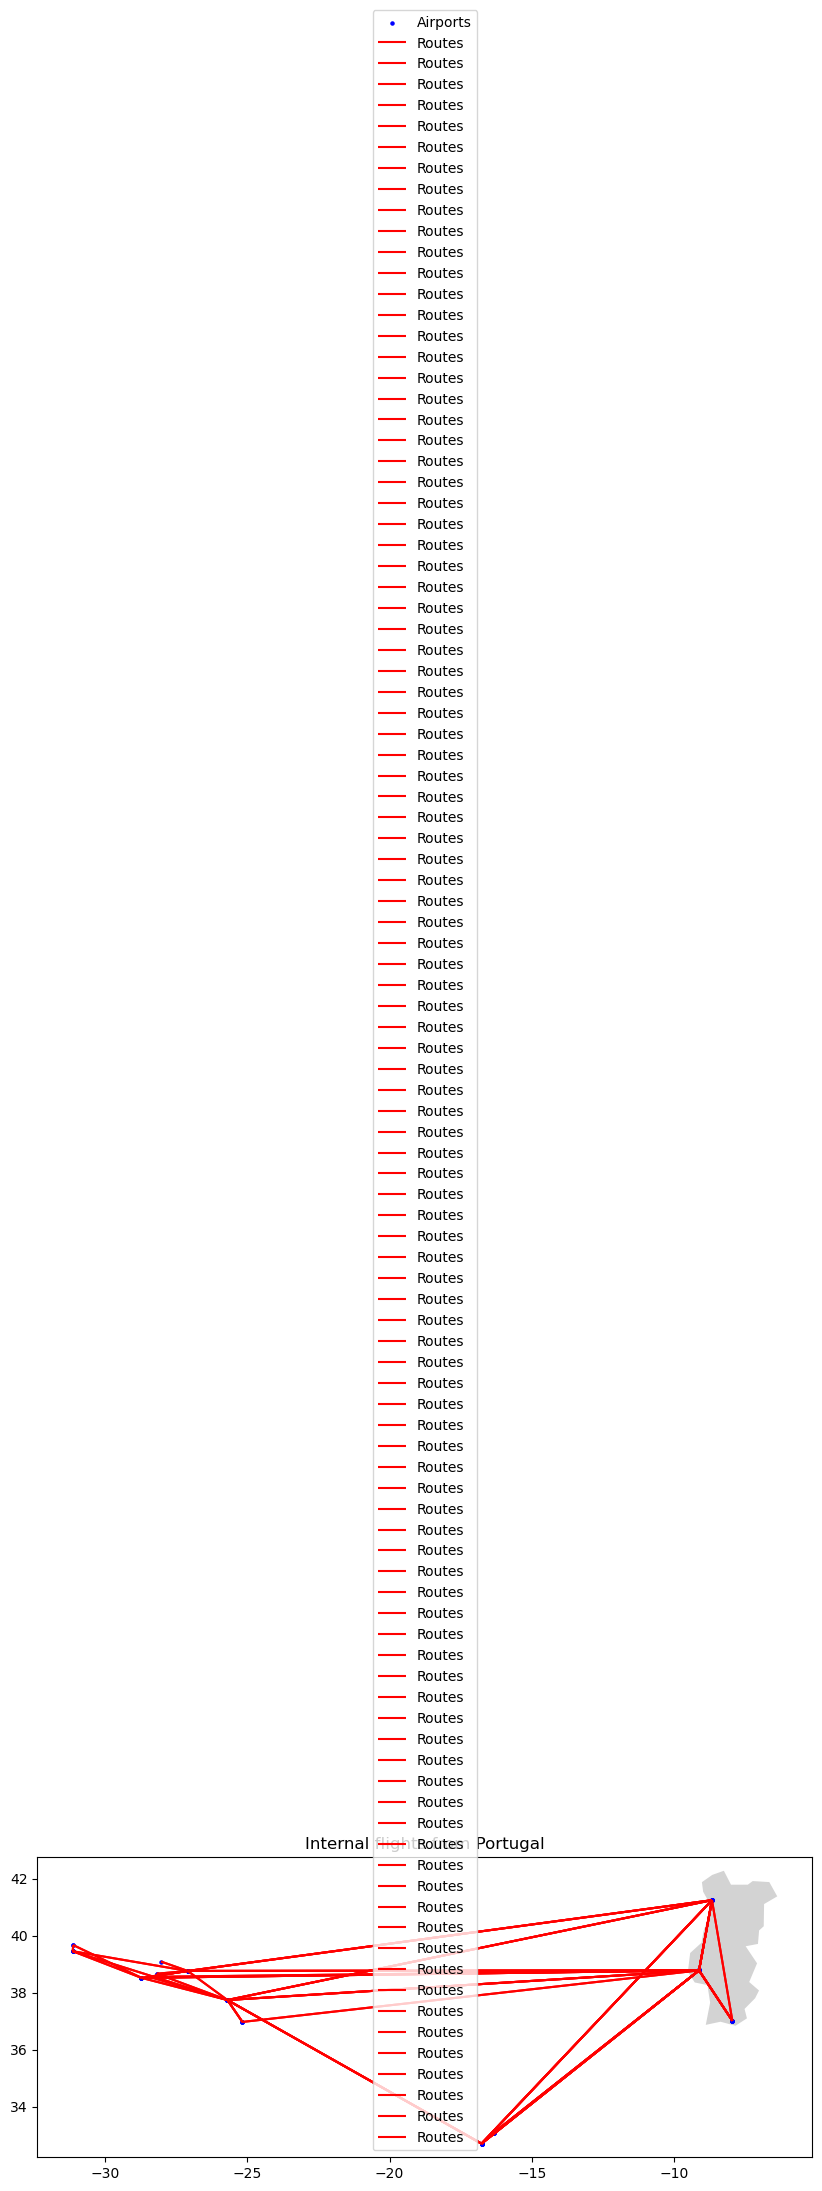

In [17]:
# Test the modified method
airplane_instance.plot_flights_by_country("Portugal", internal=True)

C:\Users\sara_\AppData\Local\Temp\ipykernel_15968\3279293656.py:297: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


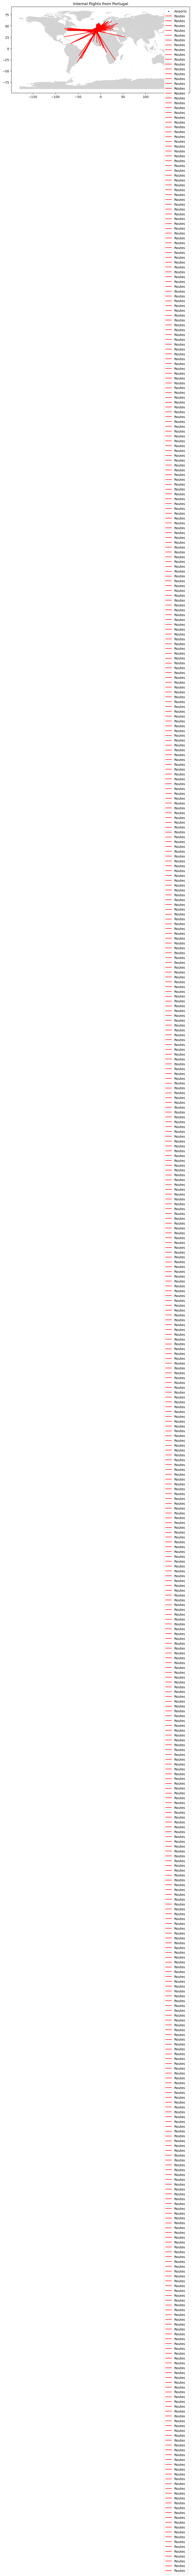

In [20]:
# Test the modified method
airplane_instance.plot_flights_by_country("Portugal")